Modularity: https://en.wikipedia.org/wiki/Modularity_(networks)

In [2]:
import torch
import numpy as np
import networkx as nx
from utils import gumbel_softmax_3d # for batch version sampling
from torch.nn.functional import gumbel_softmax # for single samping
from scipy.io import mmread
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Modularity():
    def __init__(self, G, seed=0, device='cuda:0'):
        self.G = G
        self.seed = seed
        self.device = device
        if self.seed > 0:
            torch.manual_seed(self.seed)
        self.nnodes = G.number_of_nodes()
        self.nedges = G.number_of_edges()
        self.mod_mat = nx.modularity_matrix(G).astype(np.float32)
        
    def gumbel_optimization(self, ncoms, bs=128, max_iters=2000, lr=1, init_tau=20, final_tau=0.1, diff=1e-8):
        """drop temperature from 20 to 0.1 in 2000 steps. You can choose to fix tau"""
        n = self.nnodes
        device = self.device
        B = torch.tensor(self.mod_mat, device=device)
        # we choose to directly optimize logits to avoid softmax
        x = -1 * torch.rand(bs, n, ncoms, device=device)
        x.requires_grad = True # x is learnable
        optimizer = torch.optim.Adam([x], lr=lr)
        tau = init_tau
        decay = (init_tau - final_tau) / max_iters
        Q_best = torch.ones(1, device=device)
        Q_best_idx = 0
        for i in range(max_iters):
            Q_old = Q_best.clone()
            optimizer.zero_grad()
            s = gumbel_softmax_3d(x, tau=tau, hard=True) # [bs, n, ncoms]
            mod_list = [torch.trace(s[idx, :, :].t() @ B @ s[idx, :, :]) for idx in range(bs)]
            mod_tensor = torch.stack(mod_list) # convert list to torch.tensor
            loss = -1 * torch.mean(mod_tensor)
            loss.backward()
            optimizer.step()
            tau -= decay # drop temperature
            with torch.no_grad():
                s = gumbel_softmax_3d(x, tau=tau, hard=True) # [bs, n, ncoms]
                mod_list = [torch.trace(s[j, :, :].t() @ B @ s[j, :, :]) for j in range(bs)]
                mod_tensor = torch.stack(mod_list) # we will select the best result from this list
                Q = torch.max(mod_tensor)
                idx = torch.argmax(mod_tensor)
                if Q > Q_best:
                    Q_best = Q
                    Q_best_idx = idx
                if torch.abs(Q - Q_old) < diff:
                    break
#                 print('Current best result: %.5f' % (Q_best.cpu().numpy()/ (2 * self.nedges)))
        Q_best = Q_best.cpu().numpy() / (2 * self.nedges)
        best_partition = s[Q_best_idx, :, :].cpu().numpy() # select the best partion
        print('Best Q value with %i communities: %.5f' % (ncoms, Q_best))
        return Q_best, best_partition

# Test on GN benckmark

/home/liujing/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


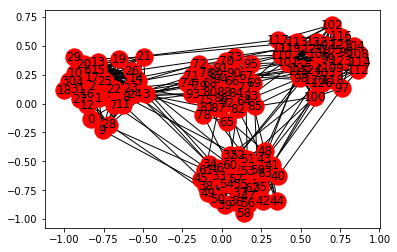

In [3]:
z_out=1
z_in=16-z_out
p_out=z_out/96
p_in=z_in/31
G = nx.random_partition_graph([32,32,32,32], p_in, p_out, seed=2050)
pos=nx.layout.spring_layout(G)
nx.draw_networkx(G, pos)

In [4]:
mod = Modularity(G)
Q, partition = mod.gumbel_optimization(4, bs=128)

Best Q value with 4 communities: 0.68608


# Zachary network

In [6]:
# load data
G = nx.karate_club_graph()
mod = Modularity(G)

In [29]:
a = [0, 1, 88, 88, 4]

In [30]:
b = [2, 3, 4, 5, 6]

In [32]:
a.index(max(a))

2

In [35]:
results.index(max(results))

1

In [7]:
Q, partition = mod.gumbel_optimization(4)

# for num_com in range(2, 6):
#     results = []
#     partitions = []
#     for _ in range(5):
#         Q, partition = mod.gumbel_optimization(num_com)
#         results.append(Q)
#         partitions.append(partition.sum(0))
#     Q_max = max(results)
#     index = results.index(Q_max)
#     print('Best results: %.5f' % (Q_max))
#     print('Partition checking:' + str(partitions[index]))
#     print('\n')
    

Best Q value with 4 communities: 0.41979


In [8]:
Q

0.41978958325508314

In [15]:
n, _ = partition.shape

In [28]:
partition_dict = {}
for i in range(n):
    temp = np.where(partition[i]==1)[0]
    partition_dict[i] = int(temp)

In [29]:
partition_dict

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 2,
 5: 2,
 6: 2,
 7: 1,
 8: 0,
 9: 0,
 10: 2,
 11: 2,
 12: 1,
 13: 1,
 14: 0,
 15: 0,
 16: 2,
 17: 1,
 18: 0,
 19: 1,
 20: 0,
 21: 1,
 22: 0,
 23: 3,
 24: 3,
 25: 3,
 26: 0,
 27: 3,
 28: 3,
 29: 0,
 30: 0,
 31: 3,
 32: 0,
 33: 0}

/home/liujing/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


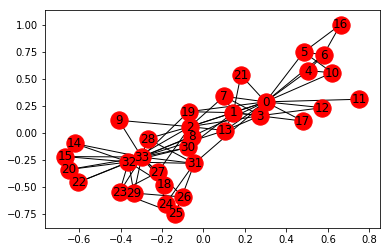

In [31]:
pos=nx.layout.spring_layout(G)
nx.draw_networkx(G, pos)

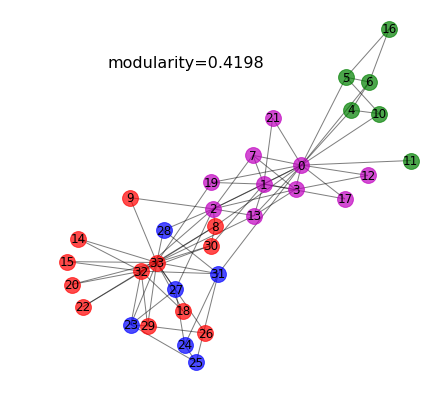

In [50]:
# Louvain Community Detection
# partition = community.best_partition(G)

partition = partition_dict
plt.figure(figsize=(7,7))
plt.tight_layout()
colors=["r",'m','g',"b",]
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 250,
                                node_color = colors[com],alpha=0.7)

nx.draw_networkx_edges(G,pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
# q=community.modularity(partition,G)
plt.text(-0.5,0.8,"modularity=%.4f"%(0.4198),fontsize=16)
# plt.show()
plt.savefig('mod.pdf', dpi=300)

# bio

In [4]:
# laod data
def load_graph(filename):
    G = nx.Graph() # undirected graphs
    for line in open(filename):
        strlist = line.split(' ')
        n1 = int(strlist[0])
        n2 = int(strlist[1])
#         weight = float(strlist[w_index])
#         G.add_weighted_edges_from([(n1, n2, weight)])
        G.add_edges_from([(n1, n2)])
    return G

G = load_graph('./data/bio-celegans.edges')

mod = Modularity(G)

In [5]:
G.number_of_nodes()

453

# Jazz

In [45]:
# load data
data = mmread('./data/jazz.mtx')
F = nx.from_scipy_sparse_matrix(data)
G = nx.Graph()
for edge in F.edges():
    G.add_edges_from([edge])

mod = Modularity(G)

In [47]:
G.nodes()

NodeView((0, 7, 23, 34, 41, 45, 59, 73, 77, 80, 94, 97, 98, 99, 100, 102, 103, 107, 130, 131, 153, 158, 167, 170, 1, 13, 53, 149, 2, 114, 152, 166, 171, 3, 4, 12, 25, 76, 84, 101, 137, 146, 155, 168, 172, 175, 188, 18, 20, 26, 27, 28, 50, 52, 56, 72, 74, 75, 78, 85, 89, 95, 96, 123, 125, 127, 135, 139, 143, 148, 154, 162, 190, 193, 195, 196, 5, 151, 156, 6, 9, 10, 35, 48, 54, 55, 60, 66, 68, 69, 70, 71, 82, 86, 92, 93, 110, 111, 112, 113, 121, 124, 126, 128, 129, 140, 145, 150, 157, 160, 163, 169, 176, 177, 184, 189, 191, 192, 194, 88, 109, 117, 120, 141, 173, 8, 22, 31, 37, 79, 115, 116, 134, 136, 138, 161, 178, 11, 17, 30, 24, 91, 147, 185, 14, 15, 47, 90, 104, 106, 16, 61, 49, 87, 182, 183, 19, 21, 42, 181, 197, 29, 33, 105, 122, 32, 39, 43, 57, 62, 63, 64, 65, 108, 118, 133, 67, 165, 186, 36, 132, 179, 38, 180, 40, 44, 58, 81, 142, 46, 51, 187, 83, 174, 119, 144, 159, 164))

In [40]:
# Q, partition = mod.gumbel_optimization(5)

# Q, partition = mod.gumbel_optimization(4)

for num_com in range(3, 7):
    results = []
    partitions = []
    for _ in range(100):
        Q, partition = mod.gumbel_optimization(num_com)
        results.append(Q)
        partitions.append(partition.sum(0))
    Q_max = max(results)
    index = results.index(Q_max)
    print('Best results: %.5f' % (Q_max))
    print('Partition checking:' + str(partitions[index]))
    print('\n')


Best Q value with 3 communities: 0.44251
Best Q value with 3 communities: 0.44044
Best Q value with 3 communities: 0.44250
Best Q value with 3 communities: 0.44155
Best Q value with 3 communities: 0.44330
Best Q value with 3 communities: 0.44254
Best Q value with 3 communities: 0.43979
Best Q value with 3 communities: 0.44289
Best Q value with 3 communities: 0.44174
Best Q value with 3 communities: 0.44213
Best Q value with 3 communities: 0.44424
Best Q value with 3 communities: 0.44267
Best Q value with 3 communities: 0.43657
Best Q value with 3 communities: 0.44205
Best Q value with 3 communities: 0.44252
Best Q value with 3 communities: 0.43995
Best Q value with 3 communities: 0.43803
Best Q value with 3 communities: 0.44406
Best Q value with 3 communities: 0.44239
Best Q value with 3 communities: 0.44159
Best Q value with 3 communities: 0.44173
Best Q value with 3 communities: 0.44200
Best Q value with 3 communities: 0.44335
Best Q value with 3 communities: 0.44365
Best Q value wit

Best Q value with 4 communities: 0.44048
Best results: 0.44499
Partition checking:[63. 53. 61. 21.]


Best Q value with 5 communities: 0.43669
Best Q value with 5 communities: 0.44155
Best Q value with 5 communities: 0.44102
Best Q value with 5 communities: 0.43813
Best Q value with 5 communities: 0.43224
Best Q value with 5 communities: 0.44029
Best Q value with 5 communities: 0.43618
Best Q value with 5 communities: 0.43786
Best Q value with 5 communities: 0.43518
Best Q value with 5 communities: 0.44221
Best Q value with 5 communities: 0.43952
Best Q value with 5 communities: 0.44055
Best Q value with 5 communities: 0.43518
Best Q value with 5 communities: 0.43931
Best Q value with 5 communities: 0.43876
Best Q value with 5 communities: 0.44018
Best Q value with 5 communities: 0.43898
Best Q value with 5 communities: 0.43843
Best Q value with 5 communities: 0.44116
Best Q value with 5 communities: 0.44242
Best Q value with 5 communities: 0.43720
Best Q value with 5 communities: 0.44

Best Q value with 6 communities: 0.43780
Best Q value with 6 communities: 0.44031
Best Q value with 6 communities: 0.43440
Best Q value with 6 communities: 0.43412
Best results: 0.44362
Partition checking:[68. 62.  1.  2. 65.  0.]




# Email

In [11]:
# laod data
def load_graph(filename):
    G = nx.Graph() # undirected graphs
    for line in open(filename):
        strlist = line.split(' ')
        n1 = int(strlist[0])
        n2 = int(strlist[1])
#         weight = float(strlist[w_index])
#         G.add_weighted_edges_from([(n1, n2, weight)])
        G.add_edges_from([(n1, n2)])
    return G

G = load_graph('./data/email-univ.edges')

mod = Modularity(G)

In [12]:
# Q, partition = mod.gumbel_optimization(5)

# Q, partition = mod.gumbel_optimization(4)

for num_com in range(3, 7):
    results = []
    partitions = []
    for _ in range(100):
        Q, partition = mod.gumbel_optimization(num_com)
        results.append(Q)
        partitions.append(partition.sum(0))
    Q_max = max(results)
    index = results.index(Q_max)
    print('Best results: %.5f' % (Q_max))
    print('Partition checking:' + str(partitions[index]))
    print('\n')


Current best result: 0.01376
Current best result: 0.03291
Current best result: 0.06260
Current best result: 0.08824
Current best result: 0.11831
Current best result: 0.15342
Current best result: 0.17995
Current best result: 0.20623
Current best result: 0.22872
Current best result: 0.25828
Current best result: 0.27741
Current best result: 0.28751
Current best result: 0.30029
Current best result: 0.31133
Current best result: 0.32637
Current best result: 0.33721
Current best result: 0.34152
Current best result: 0.35714
Current best result: 0.36155
Current best result: 0.36553
Current best result: 0.37420
Current best result: 0.37835
Current best result: 0.38692
Current best result: 0.39032
Current best result: 0.39203
Current best result: 0.40223
Current best result: 0.40675
Current best result: 0.41114
Current best result: 0.41312
Current best result: 0.41534
Current best result: 0.42069
Current best result: 0.42099
Current best result: 0.42445
Current best result: 0.43156
Current best r

In [13]:
partition.sum(0)

array([ 80.,  72.,  60.,  90., 128.,  84., 145.,  89.,  54.,  84., 119.,
        75.,  53.], dtype=float32)